In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
numerical_columns = ['goal','backers_count','usd_pledged','name_len_clean','blurb_len_clean','create_to_launch_days','launch_to_deadline_days','launch_to_state_change_days']
scaler = StandardScaler()

df = pd.read_excel('../data/Kickstarter.xlsx')
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]
df = df.dropna()

df.drop(['pledged'], axis=1, inplace=True)

# convert goal to usd
df['goal'] = df['goal']*df['static_usd_rate']

# drop columns for curerncy conversion
df.drop(['static_usd_rate', 'currency'], axis=1, inplace=True)

# drop all columns that have the same value
df.drop(['disable_communication'], axis=1, inplace=True)

# drop deadline_at, state_change_at, created_at, launched_at since the pre-processing is already done in other columns
df.drop(['deadline', 'created_at', 'launched_at','state_changed_at'], axis=1, inplace=True)

# remove outliers
z_scores = np.abs(stats.zscore(df['goal']))
df = df[(z_scores < 3)]
z_scores = np.abs(stats.zscore(df['usd_pledged']))
df = df[(z_scores < 3)]

df.drop(['id', 'name'], axis=1, inplace=True)

# drop time information that is too granular
df.drop(['created_at_hr', 'launched_at_hr',
        'deadline_hr','state_changed_at_hr'], axis=1, inplace=True)
df.drop(['launched_at_day', 'launched_at_month', 'launched_at_yr',
        'launched_at_weekday'], axis=1, inplace=True)
df.drop(['created_at_weekday','state_changed_at_weekday','deadline_weekday'],axis=1,inplace=True)
df.drop(['created_at_day','state_changed_at_day','deadline_day'],axis=1,inplace=True)

# these are highly correlated with state_changed_at_yr
df.drop(['created_at_yr','deadline_yr'], axis=1, inplace=True)

# highly correlated with name_len_clean and blurb_len_clean
df.drop(['name_len', 'blurb_len'], axis=1, inplace=True)

df = pd.get_dummies(data=df, columns=['state'], drop_first=True)
df = pd.get_dummies(data=df, columns=['country'], drop_first=True)
df = pd.get_dummies(
    data=df, columns=['created_at_month','state_changed_at_month','deadline_month'], drop_first=True)


df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df = pd.get_dummies(data=df,columns=['category'],drop_first=True)
df = pd.get_dummies(data=df,columns=['state_changed_at_yr'],drop_first=True)
df.rename({"state_successful":"state"},axis=1,inplace=True)


In [3]:
X = df.drop(['state'],axis=1)
y = df['state']



In [4]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3)
model = kmeans.fit(df)

/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


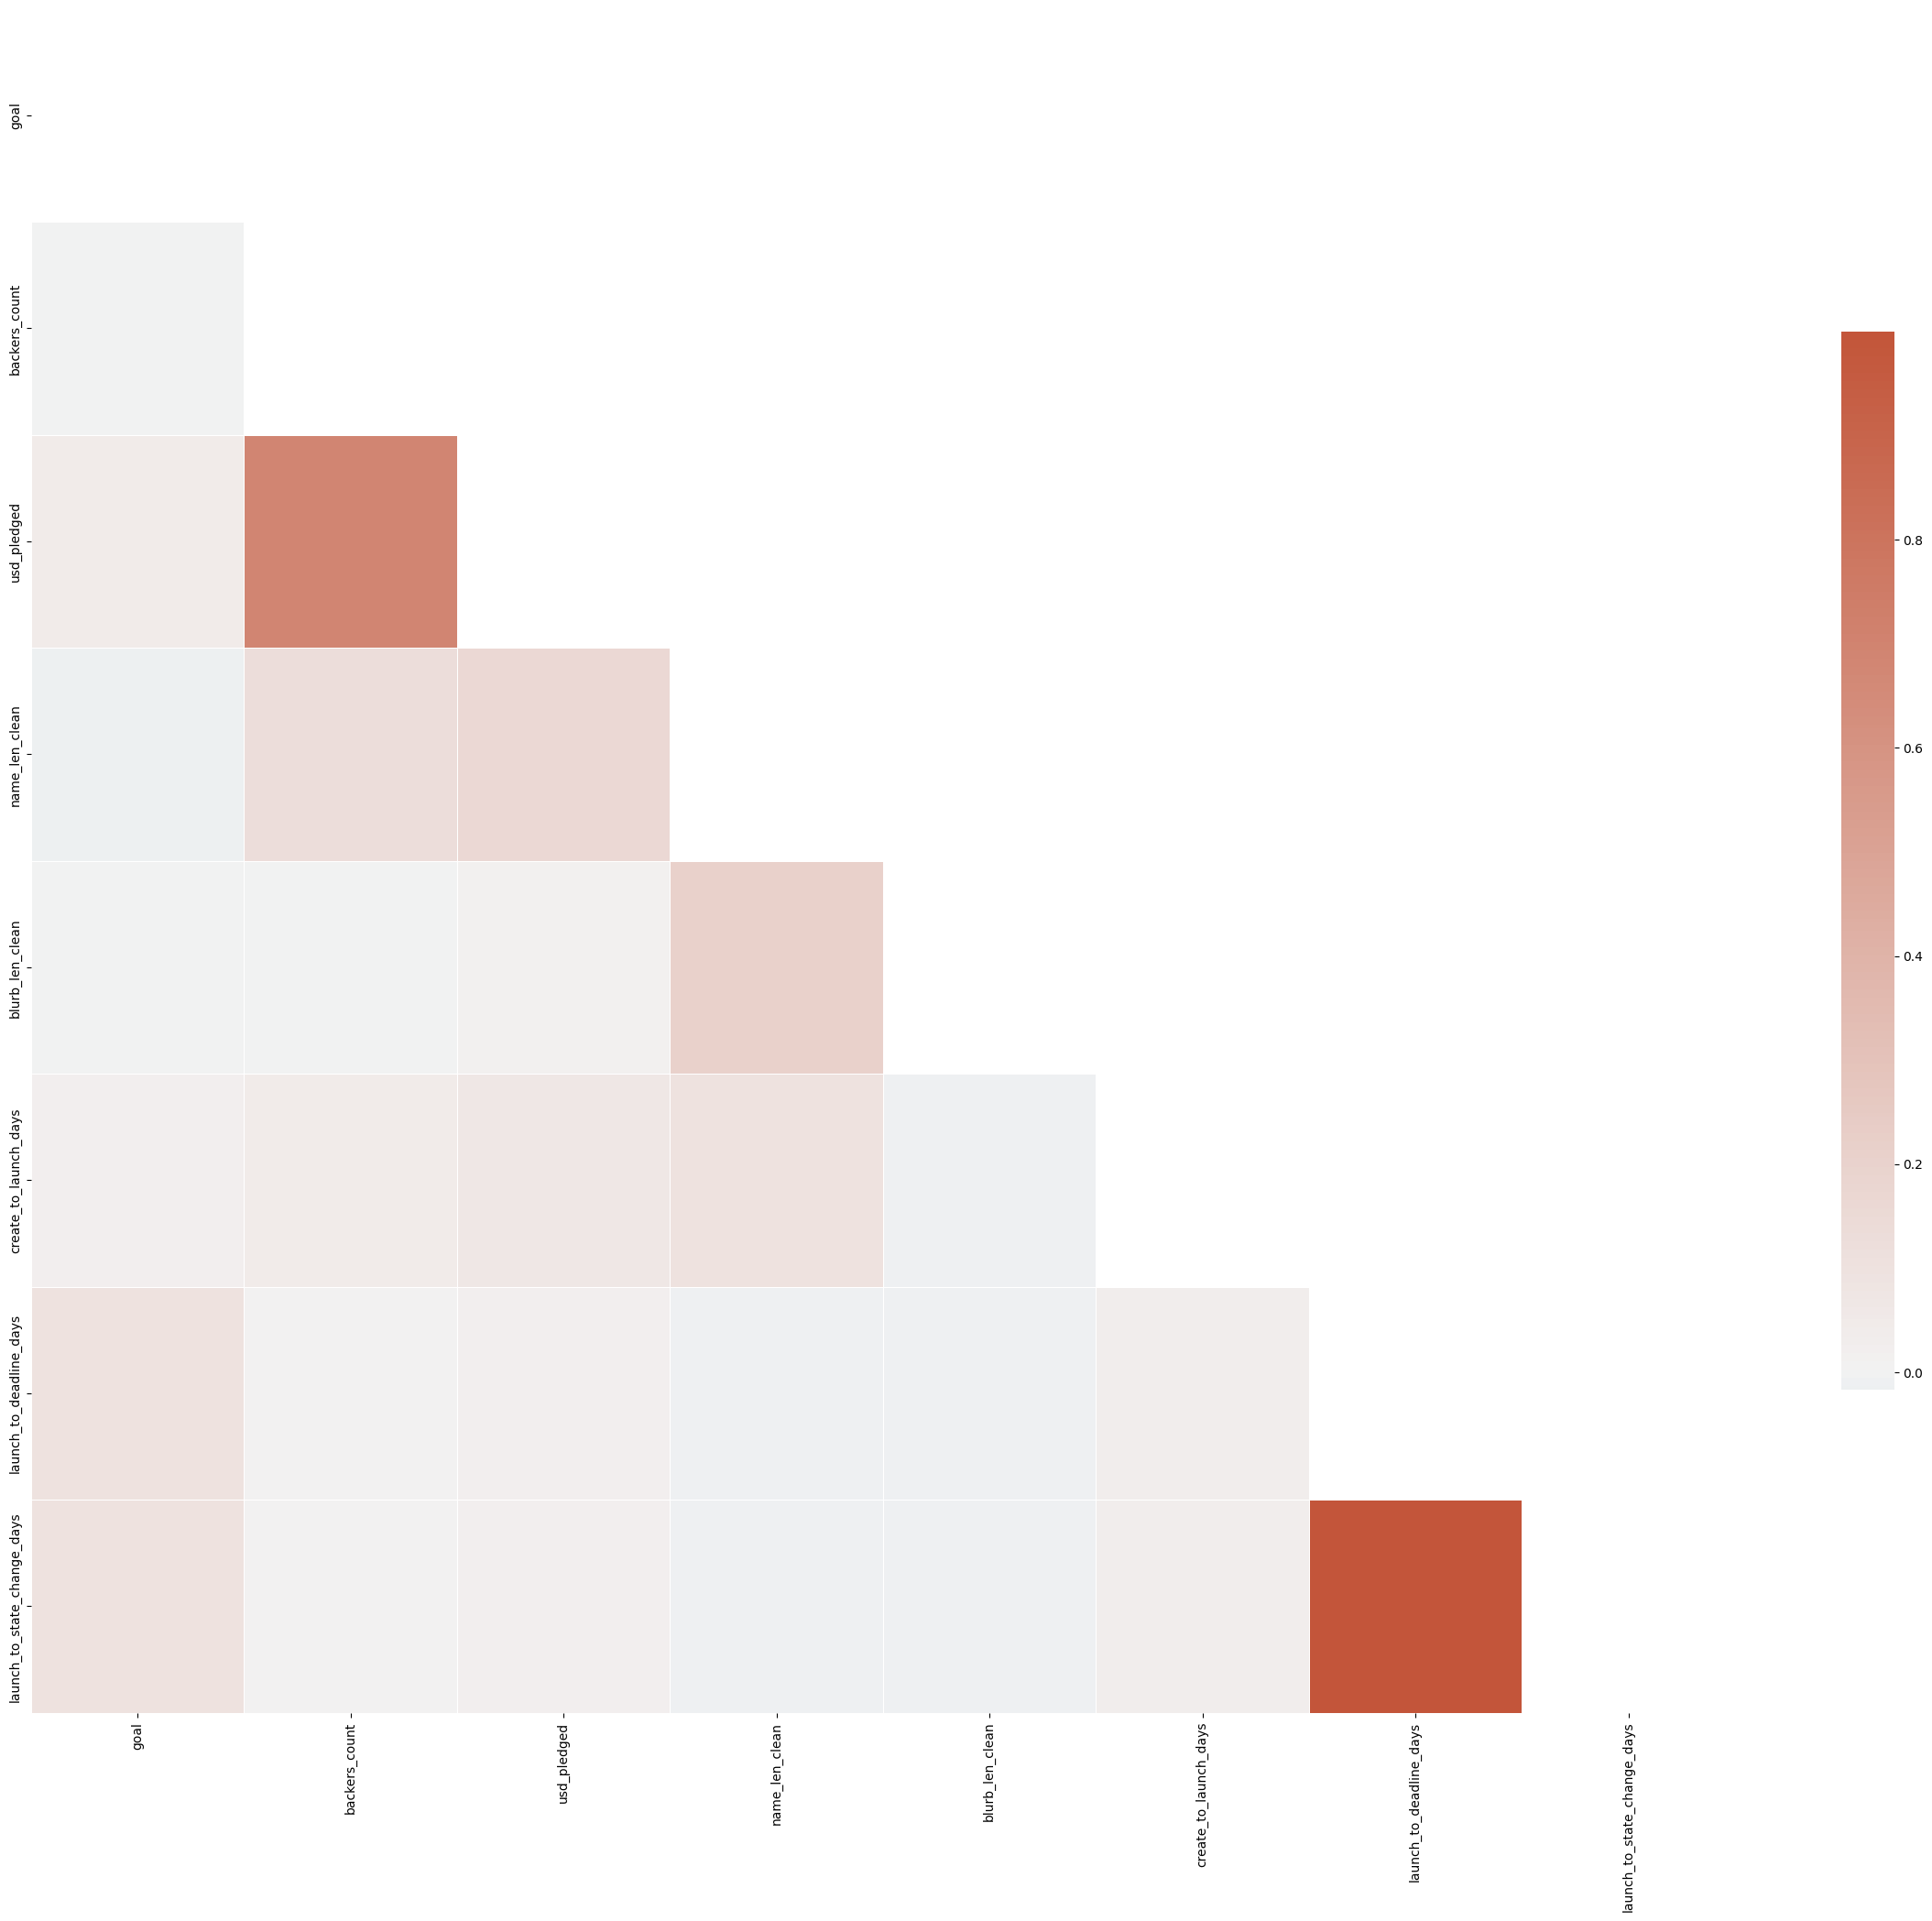

In [5]:
# get columns that are numeric
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# plot correlation matrix
corr = df[numeric_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=90)
plt.show()

In [6]:
# train test split
from sklearn.model_selection import train_test_split
df.rename({"state_successful":"state"},axis=1,inplace=True)
X = df.drop(['state'],axis=1)
y = df['state']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

## Hierarchical clustering 

Text(0.5, 1.0, 'Silhouette score vs Number of clusters')

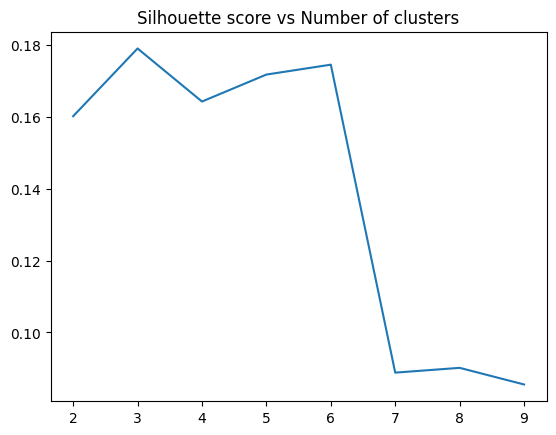

In [7]:
# hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import fowlkes_mallows_score, silhouette_score, calinski_harabasz_score

# elbow method
scores = []
for n_clusters in range(2, 10):
    scores.append(
        silhouette_score(X_train, AgglomerativeClustering(n_clusters=n_clusters).fit_predict(X_train)))
plt.plot(range(2, 10), scores)
plt.title("Silhouette score vs Number of clusters")

In [8]:
# use grid search to find the best parameters for agglomerative clustering
from sklearn.model_selection import GridSearchCV

params = {'n_clusters':range(2,10),'linkage':['ward','complete','average'],"affinity":['euclidean','l1','l2','manhattan','cosine']}
# grid = GridSearchCV(AgglomerativeClustering(),params)
i_list = []
j_list = []
k_list = []
FMS = []
sil_score = []
psedo_f = []


for i in range(2,10):
    for j in ['ward','complete','average']:
        for k in ['euclidean','l1','l2','manhattan','cosine']:
            if j == 'ward' and k != 'euclidean':
                continue
            model = AgglomerativeClustering(n_clusters=i,linkage=j,affinity=k)
            grid = model.fit(df)
            labels = grid.labels_
            i_list.append(i)
            j_list.append(j)
            k_list.append(k)
            sil_score.append(silhouette_score(df,labels))
            # FMS.append(fowlkes_mallows_score(df,labels))
            psedo_f.append(calinski_harabasz_score(df,labels))

/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:100

In [9]:
res = pd.DataFrame({"n_clusters":i_list,"linkage":j_list,"affinity":k_list,"silouette":sil_score,"psedo_f":psedo_f})
res.sort_values(by=['silouette'],ascending=False)

,n_clusters,linkage,affinity,silouette,psedo_f
3,2,complete,l2,0.778484,275.120227
1,2,complete,euclidean,0.778484,275.120227
7,2,average,l1,0.767862,282.019875
9,2,average,manhattan,0.767862,282.019875
6,2,average,euclidean,0.755769,425.134985
...,...,...,...,...,...
82,9,complete,cosine,-0.007264,401.700256
49,6,complete,cosine,-0.009671,468.117404
60,7,complete,cosine,-0.013500,408.373503
38,5,complete,cosine,-0.018386,502.978493


In [10]:
agglo_model = AgglomerativeClustering(n_clusters=2,linkage='complete',affinity='l1')
agglo_model.fit(df)
labels = agglo_model.labels_
agglo_res = df.copy()
agglo_res['cluster'] = labels
agglo_res

/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


,goal,staff_pick,backers_count,usd_pledged,spotlight,name_len_clean,blurb_len_clean,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,...,category_Web,category_Webseries,state_changed_at_yr_2010,state_changed_at_yr_2011,state_changed_at_yr_2012,state_changed_at_yr_2013,state_changed_at_yr_2014,state_changed_at_yr_2015,state_changed_at_yr_2016,cluster
0,-0.159661,False,-0.128237,-0.106643,False,1.202693,0.298765,0.154108,-0.372912,-0.372920,...,False,False,False,False,False,False,False,False,True,1
4,-0.290137,False,-0.212616,-0.274203,True,-0.040512,-0.016509,-0.447159,-1.704986,-1.704998,...,False,False,False,False,False,False,False,False,True,1
5,-0.283428,False,-0.224019,-0.248327,True,-0.454913,0.298765,-0.250023,2.124728,2.124727,...,False,False,False,False,False,False,False,False,True,1
6,-0.068762,False,-0.258227,-0.314223,False,-1.283716,0.614039,-0.230309,0.209871,0.209865,...,False,False,False,False,False,False,False,False,True,1
7,-0.294025,False,4.309693,0.872499,True,1.617095,-0.331784,-0.447159,-0.372912,-0.372920,...,False,False,False,False,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15467,-0.295503,False,-0.221739,-0.320401,False,-0.454913,-2.853978,-0.457016,2.041473,2.041472,...,False,False,False,False,False,False,False,False,False,1
15469,-0.286783,False,-0.278752,-0.336522,False,-1.698118,0.614039,-0.457016,2.291237,2.291237,...,False,False,False,False,False,False,False,False,False,1
15470,-0.301876,False,-0.274191,-0.336360,False,-0.040512,0.614039,-0.457016,-0.872440,-0.872449,...,False,False,False,False,False,False,False,False,False,1
15472,-0.300199,True,-0.055259,-0.287209,True,-0.869315,0.614039,-0.457016,0.959163,0.959159,...,False,False,False,False,False,False,False,False,False,1


## K-Means

In [11]:
# kmeans
from sklearn.cluster import KMeans
from scipy.stats import f

inertia = []
silouette = []

# Finding optimal K
for i in range (2,10):    
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(df)
    labels = model.labels_
    score = calinski_harabasz_score(df, labels)
    inertia.append(kmeans.inertia_)
    silouette.append(silhouette_score(df,labels))

    # print(i,'silhouette score:',silhouette_score(df,labels))

/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

In [12]:
silouette

[0.1817752132168713,
 0.19176639539414428,
 0.09545785918566348,
 0.0993954060460471,
 0.10539535887430933,
 0.09353366308616047,
 0.09596475691671821,
 0.08900649312852113]

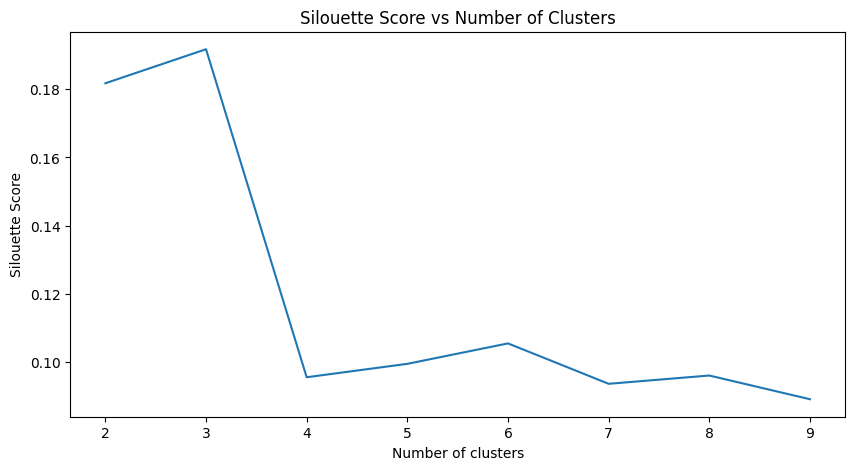

In [13]:
plt.figure(figsize=(10,5))
plt.plot(range(2, 10), silouette)
plt.title('Silouette Score vs Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silouette Score')
plt.show()

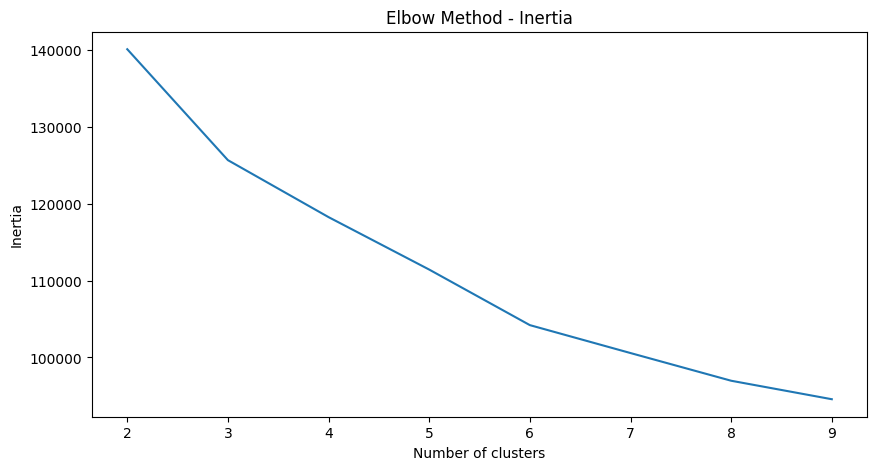

In [14]:
plt.figure(figsize=(10,5))
plt.plot(range(2, 10), inertia)
plt.title('Elbow Method - Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [15]:
# choose the best k
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
model = kmeans.fit(df)

# look at charactereistics of each cluster
df_cluster = df.copy()
df_cluster['cluster'] = model.labels_
k_means_res = df_cluster

# #convert the standardized data back to original scale
k_means_res[numerical_columns] = scaler.inverse_transform(k_means_res[numerical_columns])

k_means_res

/Users/yyy/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,goal,staff_pick,backers_count,usd_pledged,spotlight,name_len_clean,blurb_len_clean,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,...,category_Web,category_Webseries,state_changed_at_yr_2010,state_changed_at_yr_2011,state_changed_at_yr_2012,state_changed_at_yr_2013,state_changed_at_yr_2014,state_changed_at_yr_2015,state_changed_at_yr_2016,cluster
0,21449.83740,False,66.0,8484.125686,False,8.0,14.0,62.0,30.0,30.0,...,False,False,False,False,False,False,False,False,True,1
4,2000.00000,False,29.0,2300.000000,True,5.0,13.0,1.0,14.0,14.0,...,False,False,False,False,False,False,False,False,True,1
5,3000.00000,False,24.0,3255.000000,True,4.0,14.0,21.0,60.0,60.0,...,False,False,False,False,False,False,False,False,True,0
6,35000.00000,False,9.0,823.000000,False,2.0,15.0,23.0,37.0,37.0,...,False,False,False,False,False,False,False,False,True,1
7,1420.35366,False,2012.0,44621.120406,True,9.0,12.0,1.0,30.0,30.0,...,False,False,False,False,False,False,False,False,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15467,1200.00000,False,25.0,595.000000,False,4.0,4.0,0.0,59.0,59.0,...,False,False,False,False,False,False,False,False,False,0
15469,2500.00000,False,0.0,0.000000,False,1.0,15.0,0.0,62.0,62.0,...,False,False,False,False,False,False,False,False,False,0
15470,250.00000,False,2.0,6.000000,False,5.0,15.0,0.0,24.0,24.0,...,False,False,False,False,False,False,False,False,False,1
15472,500.00000,True,98.0,1820.000000,True,3.0,15.0,0.0,46.0,46.0,...,False,False,False,False,False,False,False,False,False,0


In [16]:
# Assuming 'model' is your fitted KMeans model
centroids = model.cluster_centers_
centroids

array([[ 2.20859314e-01,  6.97018533e-02, -1.70914405e-01,
        -1.92058719e-01,  1.97421434e-01, -7.00640283e-02,
        -1.11743635e-02,  2.16639676e-02,  1.64130074e+00,
         1.64129853e+00,  1.97421434e-01,  3.42465753e-02,
         1.61160355e-03,  5.88235294e-02,  3.22320709e-03,
         9.66962127e-03,  7.65511684e-03,  5.23771152e-03,
         1.57131346e-02,  9.99194198e-02,  5.23771152e-03,
         1.28928284e-02,  6.23416249e-19,  1.49073328e-02,
         2.41740532e-03,  6.44641418e-03,  3.22320709e-03,
         7.17163578e-01,  7.17163578e-02,  7.05076551e-02,
         8.05801773e-02,  8.09830782e-02,  9.14585012e-02,
         1.14020951e-01,  8.29975826e-02,  8.82352941e-02,
         9.62933118e-02,  8.29975826e-02,  6.40612409e-02,
         6.24496374e-02,  8.50120870e-02,  8.05801773e-02,
         6.84931507e-02,  6.92989525e-02,  7.97743755e-02,
         9.58904110e-02,  8.82352941e-02,  8.62207897e-02,
         7.73569702e-02,  1.05157131e-01,  6.24496374e-0

In [17]:
# analysis of each cluster
# cluster 0
cluster_0 = k_means_res[k_means_res['cluster']==0]
display(cluster_0.describe())

# cluster 1
cluster_1 = k_means_res[k_means_res['cluster']==1]
display(cluster_1.describe())

# cluster 2
cluster_2 = k_means_res[k_means_res['cluster']==2]
display(cluster_2.describe())

,goal,backers_count,usd_pledged,name_len_clean,blurb_len_clean,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,cluster
count,2.482000e+03,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.0
mean,7.817334e+04,47.286060,5331.690595,4.928687,13.016922,48.563255,54.193392,54.193392,0.0
std,2.662814e+05,117.982556,13834.161458,2.441445,3.278138,102.991922,8.473378,8.473378,0.0
min,1.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,29.000000,0.0
25%,5.000000e+03,1.000000,11.273058,3.000000,11.000000,3.000000,45.000000,45.000000,0.0
50%,1.845759e+04,7.000000,296.570915,5.000000,13.000000,13.000000,59.000000,59.000000,0.0
75%,5.000000e+04,34.000000,3398.746271,7.000000,15.000000,47.000000,60.000000,60.000000,0.0
max,3.649137e+06,1553.000000,135679.000000,13.000000,28.000000,1196.000000,91.000000,91.000000,0.0


,goal,backers_count,usd_pledged,name_len_clean,blurb_len_clean,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,cluster
count,8.997000e+03,8997.000000,8997.000000,8997.000000,8997.000000,8997.000000,8997.000000,8997.000000,8997.0
mean,3.466874e+04,59.164388,5670.926082,5.054129,13.053685,44.093031,28.999444,28.999555,1.0
std,9.750804e+04,130.656904,12420.981705,2.398881,3.146191,99.417726,5.663816,5.663826,0.0
min,1.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.0
25%,3.000000e+03,2.000000,25.000000,3.000000,11.000000,3.000000,30.000000,30.000000,1.0
50%,1.000000e+04,12.000000,652.000000,5.000000,13.000000,12.000000,30.000000,30.000000,1.0
75%,3.000000e+04,53.000000,4694.365657,7.000000,15.000000,39.000000,30.000000,30.000000,1.0
max,2.000000e+06,1439.000000,109563.720000,14.000000,30.000000,1528.000000,42.000000,42.000000,1.0


,goal,backers_count,usd_pledged,name_len_clean,blurb_len_clean,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,cluster
count,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.0
mean,68868.793421,1441.707531,149572.663369,6.520140,13.185639,72.616462,35.127846,35.127846,2.0
std,63546.639965,1379.657803,75802.169672,2.038454,3.108653,120.972064,8.028640,8.028640,0.0
min,108.000000,126.000000,20082.512891,1.000000,3.000000,0.000000,14.000000,14.000000,2.0
25%,25000.000000,650.500000,97491.660217,5.000000,11.000000,17.500000,30.000000,30.000000,2.0
50%,50000.000000,1085.000000,125154.240000,7.000000,14.000000,34.000000,31.000000,31.000000,2.0
75%,100000.000000,1640.000000,189917.048196,8.000000,15.000000,72.500000,40.000000,40.000000,2.0
max,500000.000000,12578.000000,366199.000000,13.000000,21.000000,1122.000000,60.000000,60.000000,2.0


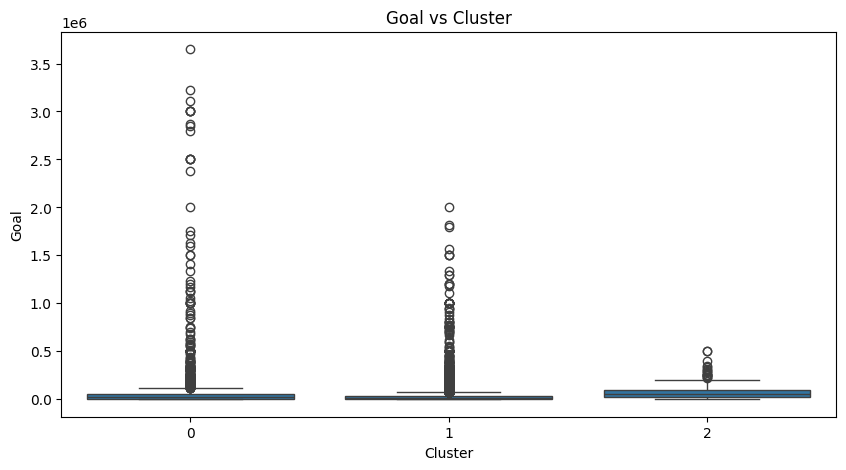

In [18]:
# distribution of goal of each cluster
plt.figure(figsize=(10,5))
sns.boxplot(x='cluster',y='goal',data=k_means_res)
plt.title('Goal vs Cluster')
plt.xlabel('Cluster')
plt.ylabel('Goal')
plt.show()


In [19]:
k_means_res

,goal,staff_pick,backers_count,usd_pledged,spotlight,name_len_clean,blurb_len_clean,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,...,category_Web,category_Webseries,state_changed_at_yr_2010,state_changed_at_yr_2011,state_changed_at_yr_2012,state_changed_at_yr_2013,state_changed_at_yr_2014,state_changed_at_yr_2015,state_changed_at_yr_2016,cluster
0,21449.83740,False,66.0,8484.125686,False,8.0,14.0,62.0,30.0,30.0,...,False,False,False,False,False,False,False,False,True,1
4,2000.00000,False,29.0,2300.000000,True,5.0,13.0,1.0,14.0,14.0,...,False,False,False,False,False,False,False,False,True,1
5,3000.00000,False,24.0,3255.000000,True,4.0,14.0,21.0,60.0,60.0,...,False,False,False,False,False,False,False,False,True,0
6,35000.00000,False,9.0,823.000000,False,2.0,15.0,23.0,37.0,37.0,...,False,False,False,False,False,False,False,False,True,1
7,1420.35366,False,2012.0,44621.120406,True,9.0,12.0,1.0,30.0,30.0,...,False,False,False,False,False,False,False,False,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15467,1200.00000,False,25.0,595.000000,False,4.0,4.0,0.0,59.0,59.0,...,False,False,False,False,False,False,False,False,False,0
15469,2500.00000,False,0.0,0.000000,False,1.0,15.0,0.0,62.0,62.0,...,False,False,False,False,False,False,False,False,False,0
15470,250.00000,False,2.0,6.000000,False,5.0,15.0,0.0,24.0,24.0,...,False,False,False,False,False,False,False,False,False,1
15472,500.00000,True,98.0,1820.000000,True,3.0,15.0,0.0,46.0,46.0,...,False,False,False,False,False,False,False,False,False,0


In [20]:
country_col_names = [col for col in k_means_res.columns if col.startswith('country_')]
country_cols = k_means_res[country_col_names]
k_means_res.drop(country_col_names,axis=1,inplace=True)
k_means_res['country'] = country_cols.idxmax(axis=1).apply(lambda x: x.replace("country_",""))


In [21]:
country_col_names = [col for col in k_means_res.columns if col.startswith('category_')]
country_cols = k_means_res[country_col_names]
k_means_res.drop(country_col_names,axis=1,inplace=True)
k_means_res['category'] = country_cols.idxmax(axis=1).apply(lambda x: x.replace("category_",""))

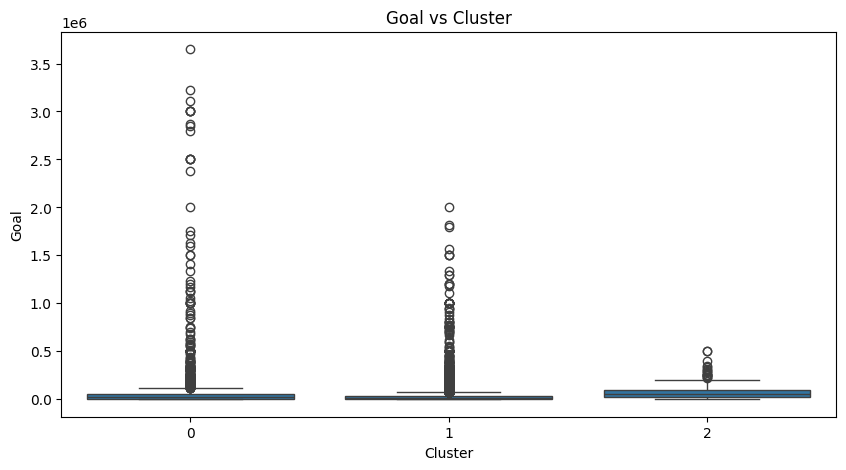

In [22]:
# distribution of goal of each cluster
plt.figure(figsize=(10,5))
sns.boxplot(x='cluster',y='goal',data=k_means_res)
plt.title('Goal vs Cluster')
plt.xlabel('Cluster')
plt.ylabel('Goal')
plt.show()

Text(0, 0.5, 'Count')

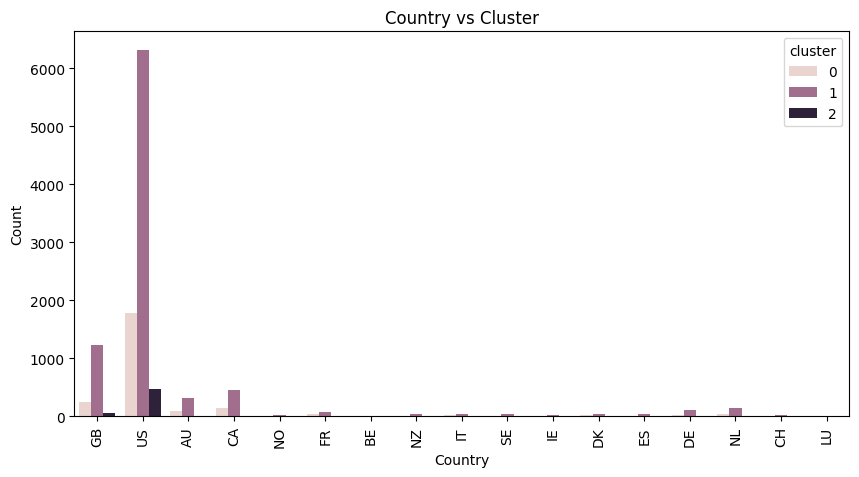

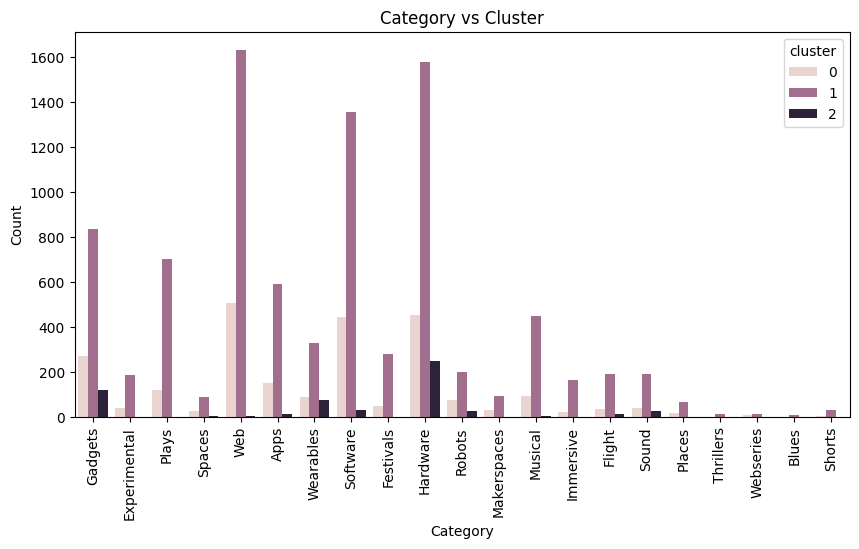

In [23]:
# plot for distribution of country vs cluster, with number of count labeled
plt.figure(figsize=(10,5))
plot = sns.countplot(x='country',hue='cluster',data=k_means_res)
plt.title('Country vs Cluster')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.ylabel('Count')

# plot for distribution of category vs cluster
plt.figure(figsize=(10,5))
sns.countplot(x='category',hue='cluster',data=k_means_res)
plt.title('Category vs Cluster')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('Count')



In [24]:
# look at the categorical features of the clusters,
# the categories are all one hot encoded, so we need to consider that
# country all starts wtih country_
# category all starts with category_
# state_changed_at_yr all starts with state_changed_at_yr_
# created_at_month all starts with created_at_month_
# state_changed_at_month all starts with state_changed_at_month_
# deadline_month all starts with deadline_month_

# cluster 0
cluster_0 = k_means_res[k_means_res['cluster']==0]
cluster_0_cat = cluster_0[[col for col in cluster_0.columns if col.startswith('category_')]]
cluster_0_cat = cluster_0_cat.sum(axis=0)
cluster_0_cat.sort_values(ascending=False,inplace=True)
print("category for cluster 1:")
display(cluster_0_cat)

# cluster 1
cluster_1 = k_means_res[k_means_res['cluster']==1]
cluster_1_cat = cluster_1[[col for col in cluster_1.columns if col.startswith('category_')]]
cluster_1_cat = cluster_1_cat.sum(axis=0)
cluster_1_cat.sort_values(ascending=False,inplace=True)
print("category for cluster 2:")
display(cluster_1_cat)

# cluster 2
cluster_2 = k_means_res[k_means_res['cluster']==2]
cluster_2_cat = cluster_2[[col for col in cluster_2.columns if col.startswith('category_')]]
cluster_2_cat = cluster_2_cat.sum(axis=0)
cluster_2_cat.sort_values(ascending=False,inplace=True)
print("category for cluster 3:")
display(cluster_2_cat)


category for cluster 1:


Series([], dtype: float64)

category for cluster 2:


Series([], dtype: float64)

category for cluster 3:


Series([], dtype: float64)

In [25]:
# look at the categorical features of the clusters,
# the categories are all one hot encoded, so we need to consider that
# country all starts wtih country_
# category all starts with country_
# state_changed_at_yr all starts with state_changed_at_yr_
# created_at_month all starts with created_at_month_
# state_changed_at_month all starts with state_changed_at_month_
# deadline_month all starts with deadline_month_

# cluster 0
cluster_0 = k_means_res[k_means_res['cluster']==0]
cluster_0_cat = cluster_0[[col for col in cluster_0.columns if col.startswith('country_')]]
cluster_0_cat = cluster_0_cat.sum(axis=0)
cluster_0_cat.sort_values(ascending=False,inplace=True)
print("category for cluster 1:")
display(cluster_0_cat)

# cluster 1
cluster_1 = k_means_res[k_means_res['cluster']==1]
cluster_1_cat = cluster_1[[col for col in cluster_1.columns if col.startswith('category_')]]
cluster_1_cat = cluster_1_cat.sum(axis=0)
cluster_1_cat.sort_values(ascending=False,inplace=True)
print("category for cluster 2:")
display(cluster_1_cat)

# cluster 2
cluster_2 = k_means_res[k_means_res['cluster']==2]
cluster_2_cat = cluster_2[[col for col in cluster_2.columns if col.startswith('country_')]]
cluster_2_cat = cluster_2_cat.sum(axis=0)
cluster_2_cat.sort_values(ascending=False,inplace=True)
print("category for cluster 3:")
display(cluster_2_cat)

category for cluster 1:


Series([], dtype: float64)

category for cluster 2:


Series([], dtype: float64)

category for cluster 3:


Series([], dtype: float64)

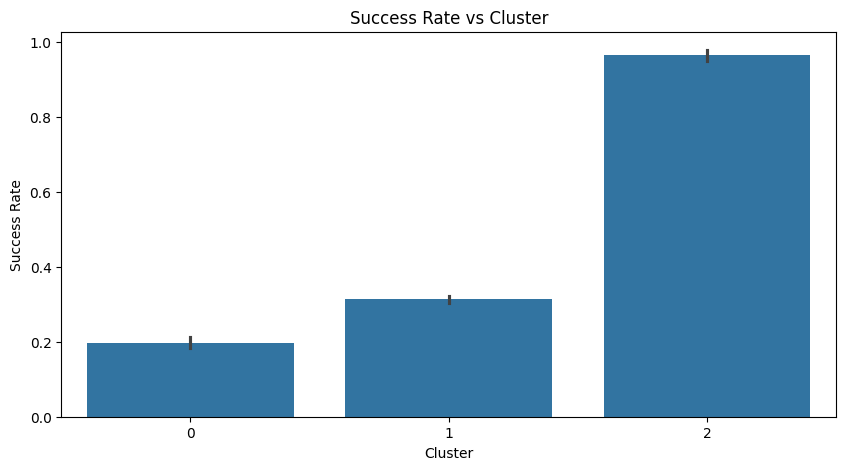

In [26]:
# plot project success rate for each cluster
plt.figure(figsize=(10,5))
sns.barplot(x='cluster',y='state',data=k_means_res)
plt.title('Success Rate vs Cluster')
plt.xlabel('Cluster')
plt.ylabel('Success Rate')
plt.show()

## DBSCAN

In [27]:
# dbscan
from sklearn.cluster import DBSCAN

silouette = []
pseudo_f_scores = []
eps_vals = []
min_sam = []

for eps in np.arange(0.1, 1, 0.1):
    for min_samples in range(2, 10):
        model = DBSCAN(eps=eps).fit(df)
        labels = model.labels_
        eps_vals.append(eps)
        min_sam.append(min_samples)
        silouette.append(silhouette_score(df,labels))
        pseudo_f_scores.append(calinski_harabasz_score(df,labels))
res_dbscan = pd.DataFrame({"eps":eps_vals,"min_samples":min_sam,"silouette":silouette,"pseudo_f_scores":pseudo_f_scores})
display(res_dbscan.sort_values(by=['silouette','pseudo_f_scores'],ascending=False))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
res_dbscan

,eps,min_samples,silouette,pseudo_f_scores
0,0.1,2,-0.318687,3.052449
1,0.1,3,-0.318687,3.052449
2,0.1,4,-0.318687,3.052449
3,0.1,5,-0.318687,3.052449
4,0.1,6,-0.318687,3.052449
...,...,...,...,...
67,0.9,5,-0.201977,19.395426
68,0.9,6,-0.201977,19.395426
69,0.9,7,-0.201977,19.395426
70,0.9,8,-0.201977,19.395426


Looks pretty bad...